In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import time
import seaborn as sns


## 数据划分

In [2]:
data = pd.read_csv("insurance_data_preprocessed.csv")
# 只保留风险评分作为目标变量
X = data.drop(['avg_claim_amount', 'total_claims_paid', 'annual_medical_cost', 'claims_count', 'risk_score', 'is_high_risk'], axis=1, errors='ignore')
y = data['is_high_risk']  # 

# 检查原始risk_score的范围
print(f"Original risk_score range: [{y.min():.3f}, {y.max():.3f}]")


# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Original risk_score range: [0.000, 1.000]


Feature correlations with risk_score (sorted):
chronic_count                      0.571784
age                                0.557669
systolic_bp                        0.429379
diastolic_bp                       0.299937
hypertension                       0.297275
visits_last_year                   0.269943
mental_health                      0.246365
annual_premium                     0.241936
monthly_premium                    0.241935
smoker                             0.236441
medication_count                   0.229232
arthritis                          0.228848
diabetes                           0.205566
asthma                             0.163955
hba1c                              0.162228
cardiovascular_disease             0.150167
proc_surgery_count                 0.143792
copd                               0.128098
had_major_procedure                0.098351
cancer_history                     0.097459
proc_imaging_count                 0.092861
proc_lab_count               

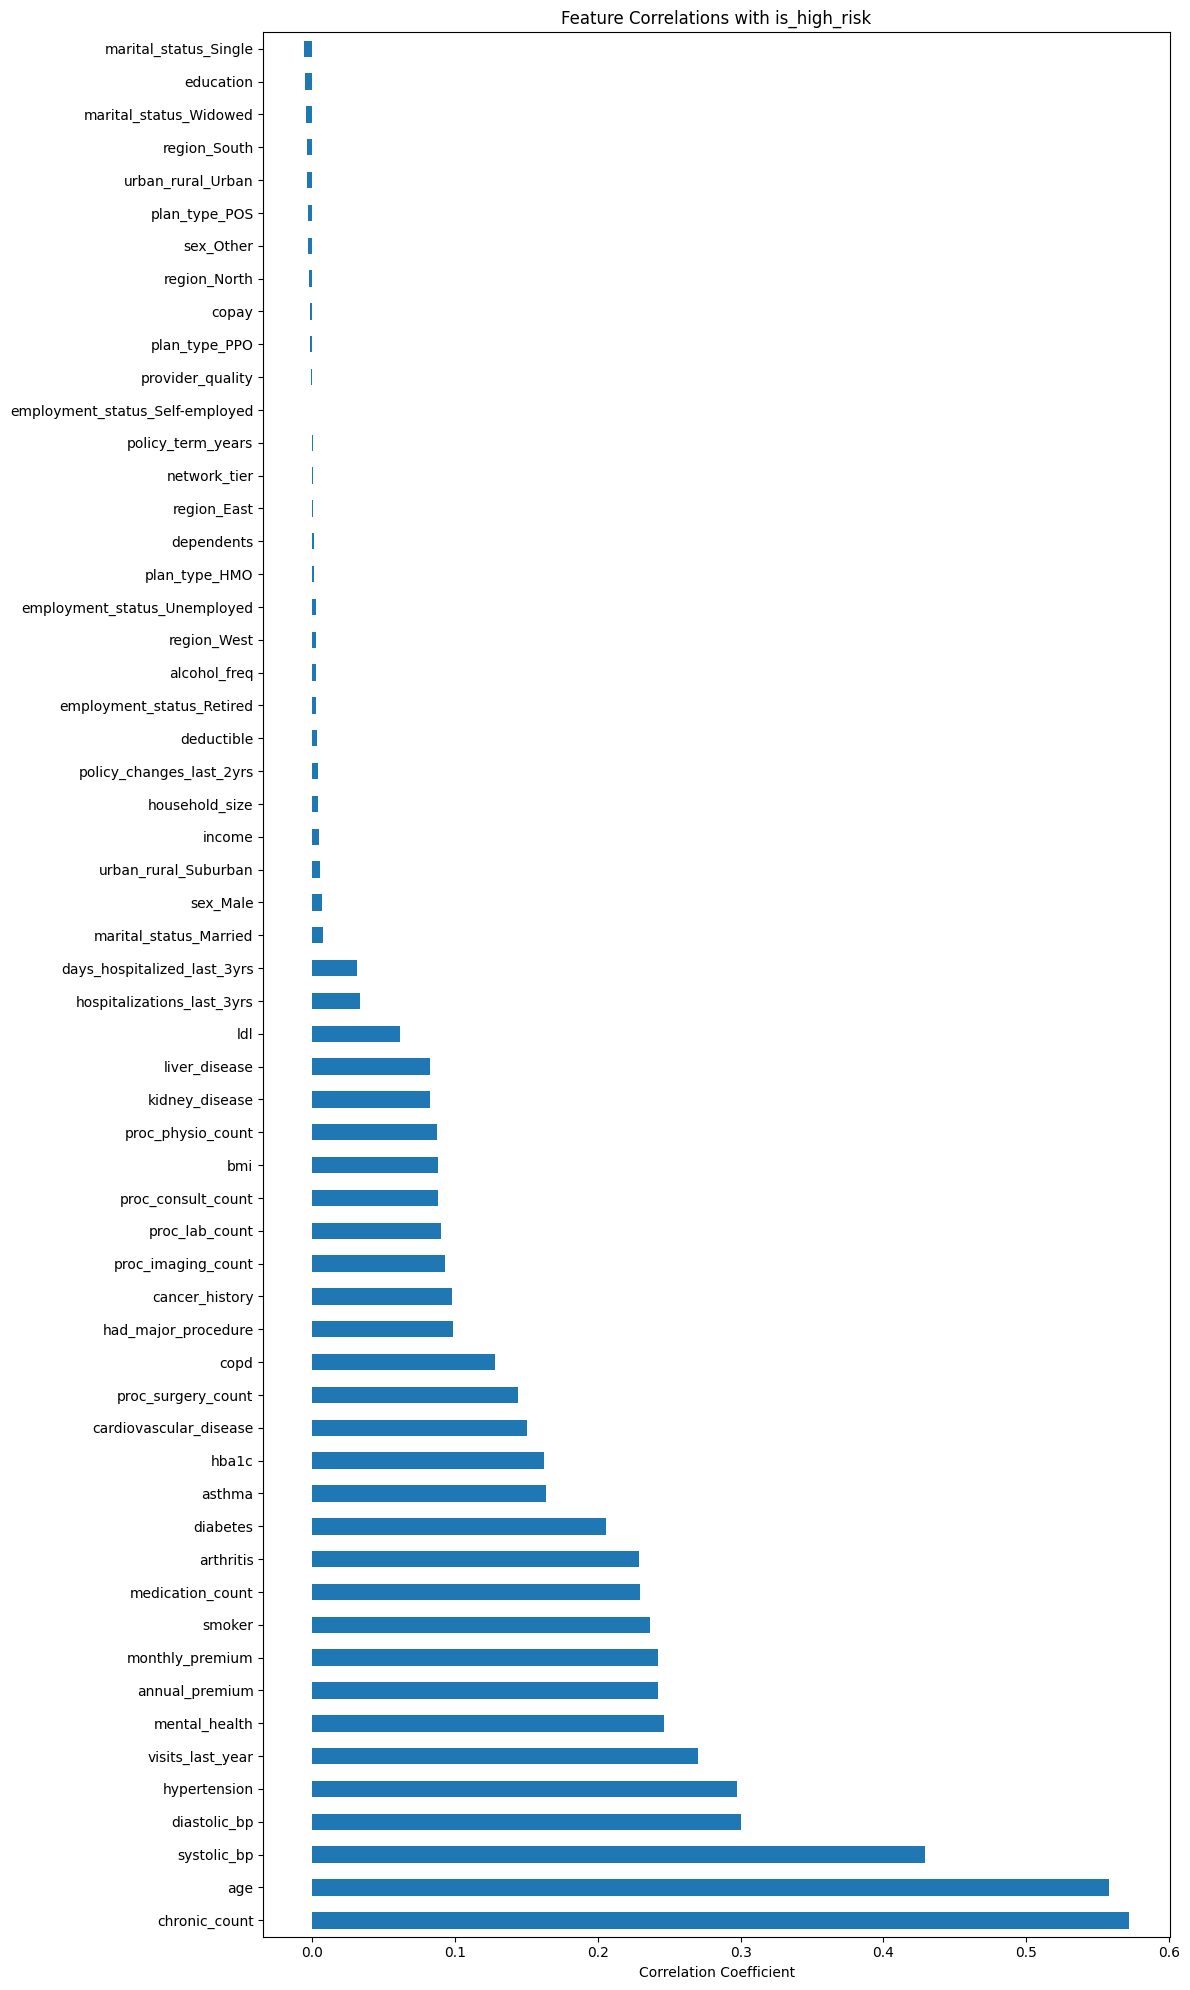

In [3]:
# Calculate correlation between all features and target variable
correlation_with_target = X.corrwith(y).sort_values(ascending=False)  # 计算 is_high_risk 与特征的相关性

print("Feature correlations with risk_score (sorted):")
print(correlation_with_target)

# Plot correlation bar chart
plt.figure(figsize=(12, 20))
correlation_with_target.plot(kind='barh')
plt.title('Feature Correlations with is_high_risk')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()


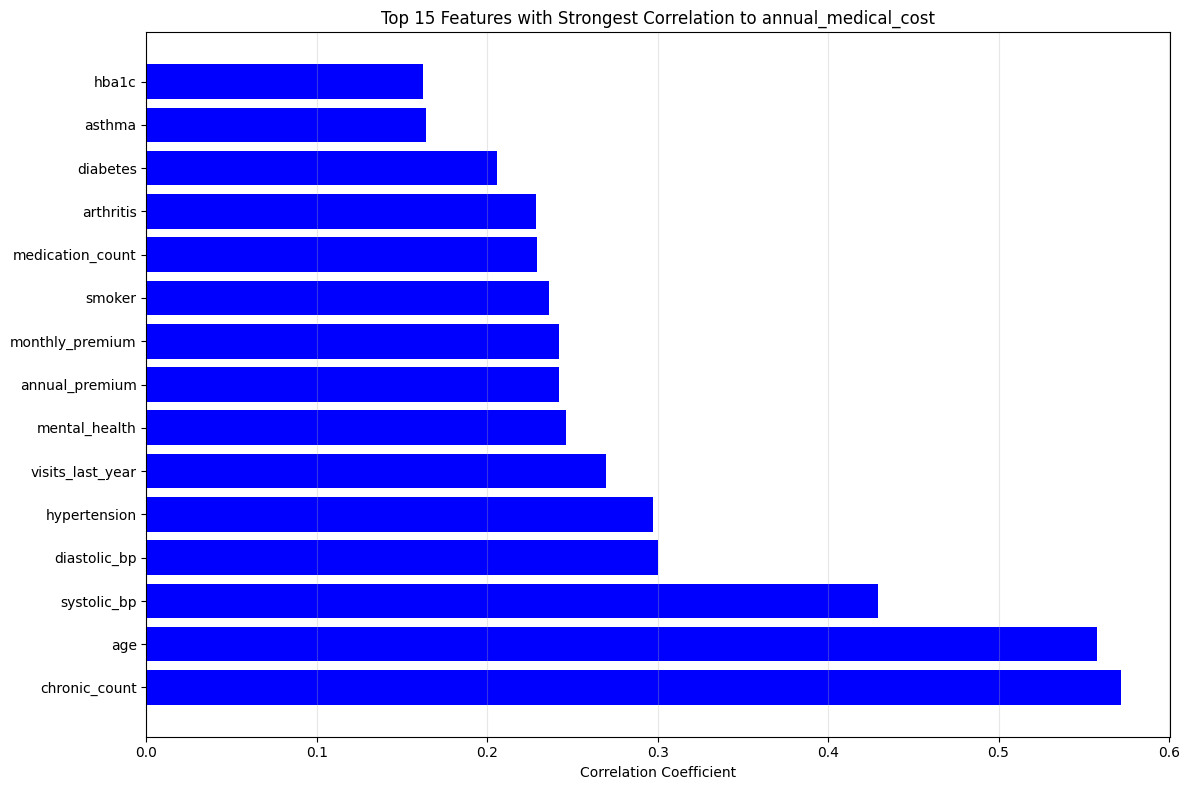

chronic_count       0.571784
age                 0.557669
systolic_bp         0.429379
diastolic_bp        0.299937
hypertension        0.297275
visits_last_year    0.269943
mental_health       0.246365
annual_premium      0.241936
monthly_premium     0.241935
smoker              0.236441
medication_count    0.229232
arthritis           0.228848
diabetes            0.205566
asthma              0.163955
hba1c               0.162228
dtype: float64

In [4]:
top_features_abs = correlation_with_target.abs().sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 8))
colors = ['red' if x < 0 else 'blue' for x in correlation_with_target[top_features_abs.index]]

plt.barh(range(len(top_features_abs)), correlation_with_target[top_features_abs.index], color=colors)
plt.yticks(range(len(top_features_abs)), top_features_abs.index)
plt.xlabel('Correlation Coefficient')
plt.title('Top 15 Features with Strongest Correlation to annual_medical_cost')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()
top_features_abs

## 分类模型(全部特征)

In [5]:
# 修正后的分类模型配置
classification_models = {
    # 决策树 - 需要最强的正则化（单棵树易过拟合）
    "Decision_Tree_Pruned": DecisionTreeClassifier(
        random_state=42,
        max_depth=15,                    # 较浅的深度
        min_samples_split=50,           # 较大的分裂阈值
        min_samples_leaf=20,            # 较大的叶节点样本
        max_features='sqrt',             # 每次分裂考虑的特征数
        ccp_alpha=0.01                   # 代价复杂度剪枝
    ),
    
    # 随机森林 - 中等正则化（集成本身抗过拟合）
    "Random_Forest_Pruned": RandomForestClassifier(
        random_state=42,
        n_estimators=100,
        max_depth=15,                   # 比决策树稍深
        min_samples_split=50,           # 比决策树宽松
        min_samples_leaf=10,
        max_features='sqrt',
        ccp_alpha=0.01  
    ),
    
    # 梯度提升 - 较弱的正则化（需要一定复杂度来学习）
    "Gradient_Boosting_Regularized": GradientBoostingClassifier(
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=10,                    # 最浅的深度（GBDT的特点）
        min_samples_split=50,
        min_samples_leaf=20, 
        subsample=0.8,                   # GBDT特有的参数
        max_features='sqrt',
        ccp_alpha=0.01  
    ),

    # 神经网络 - 简化结构并添加正则化
    "MLP_Regularized": MLPClassifier(
        hidden_layer_sizes=(50, 25),     # 简化网络结构
        activation='relu',
        solver='adam',
        alpha=0.001,                     # L2正则化参数
        batch_size=64,                   # 增大batch_size
        learning_rate='adaptive',        # 自适应学习率
        early_stopping=True,             # 早停法
        validation_fraction=0.1,         # 验证集比例
        n_iter_no_change=10,             # 早停耐心值
        max_iter=500,                    # 减少最大迭代次数
        random_state=42
    )}

In [6]:

def classification_train(X_train, X_test, y_train, y_test, models):
    n_models = len(models)
    n_cols = 2
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    if n_models == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for idx, (name, model) in enumerate(models.items()):
        time_start = time.time()
        
        # 训练模型
        model.fit(X_train, y_train)
        
        # 训练集预测
        y_train_pred = model.predict(X_train)
        
        # 测试集预测
        y_test_pred = model.predict(X_test)
        
        # 计算评估指标 - 训练集
        accuracy_train = accuracy_score(y_train, y_train_pred)
        precision_train = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
        recall_train = recall_score(y_train, y_train_pred, average='weighted', zero_division=0)
        f1_train = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)
        
        # 计算评估指标 - 测试集
        accuracy_test = accuracy_score(y_test, y_test_pred)
        precision_test = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
        recall_test = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
        f1_test = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
        
        # 绘制混淆矩阵
        ax = axes[idx]
        cm = confusion_matrix(y_test, y_test_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(f'{name} Test Accuracy: {accuracy_test:.3f}')
        
        print("Model:", name)
        print("模型在训练集上的评估结果：")
        print(f"Accuracy: {accuracy_train:.4f}")
        print(f"Precision: {precision_train:.4f}")
        print(f"Recall: {recall_train:.4f}")
        print(f"F1-Score: {f1_train:.4f}")
        print()
        
        print("模型在测试集上的评估结果：")
        print(f"Accuracy: {accuracy_test:.4f}")
        print(f"Precision: {precision_test:.4f}")
        print(f"Recall: {recall_test:.4f}")
        print(f"F1-Score: {f1_test:.4f}")
        print('-'*50)
        
        # 显示详细分类报告
        # print("详细分类报告：")
        # print(classification_report(y_test, y_test_pred, zero_division=0))
        
        time_end = time.time()
        print(f"训练时间: {time_end - time_start:.2f}秒")
        print()

    # 隐藏多余的子图
    for idx in range(len(models), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle('Confusion Matrix in all model', fontsize=16, y=1.02)
    plt.show()

Model: Decision_Tree_Pruned
模型在训练集上的评估结果：
Accuracy: 0.7655
Precision: 0.7831
Recall: 0.7655
F1-Score: 0.7685

模型在测试集上的评估结果：
Accuracy: 0.7669
Precision: 0.7856
Recall: 0.7669
F1-Score: 0.7699
--------------------------------------------------
训练时间: 0.69秒

Model: Random_Forest_Pruned
模型在训练集上的评估结果：
Accuracy: 0.9066
Precision: 0.9123
Recall: 0.9066
F1-Score: 0.9045

模型在测试集上的评估结果：
Accuracy: 0.9068
Precision: 0.9131
Recall: 0.9068
F1-Score: 0.9046
--------------------------------------------------
训练时间: 16.42秒

Model: Gradient_Boosting_Regularized
模型在训练集上的评估结果：
Accuracy: 0.8962
Precision: 0.9066
Recall: 0.8962
F1-Score: 0.8928

模型在测试集上的评估结果：
Accuracy: 0.8963
Precision: 0.9072
Recall: 0.8963
F1-Score: 0.8929
--------------------------------------------------
训练时间: 14.42秒

Model: MLP_Regularized
模型在训练集上的评估结果：
Accuracy: 0.9198
Precision: 0.9204
Recall: 0.9198
F1-Score: 0.9200

模型在测试集上的评估结果：
Accuracy: 0.9218
Precision: 0.9225
Recall: 0.9218
F1-Score: 0.9220
--------------------------------------

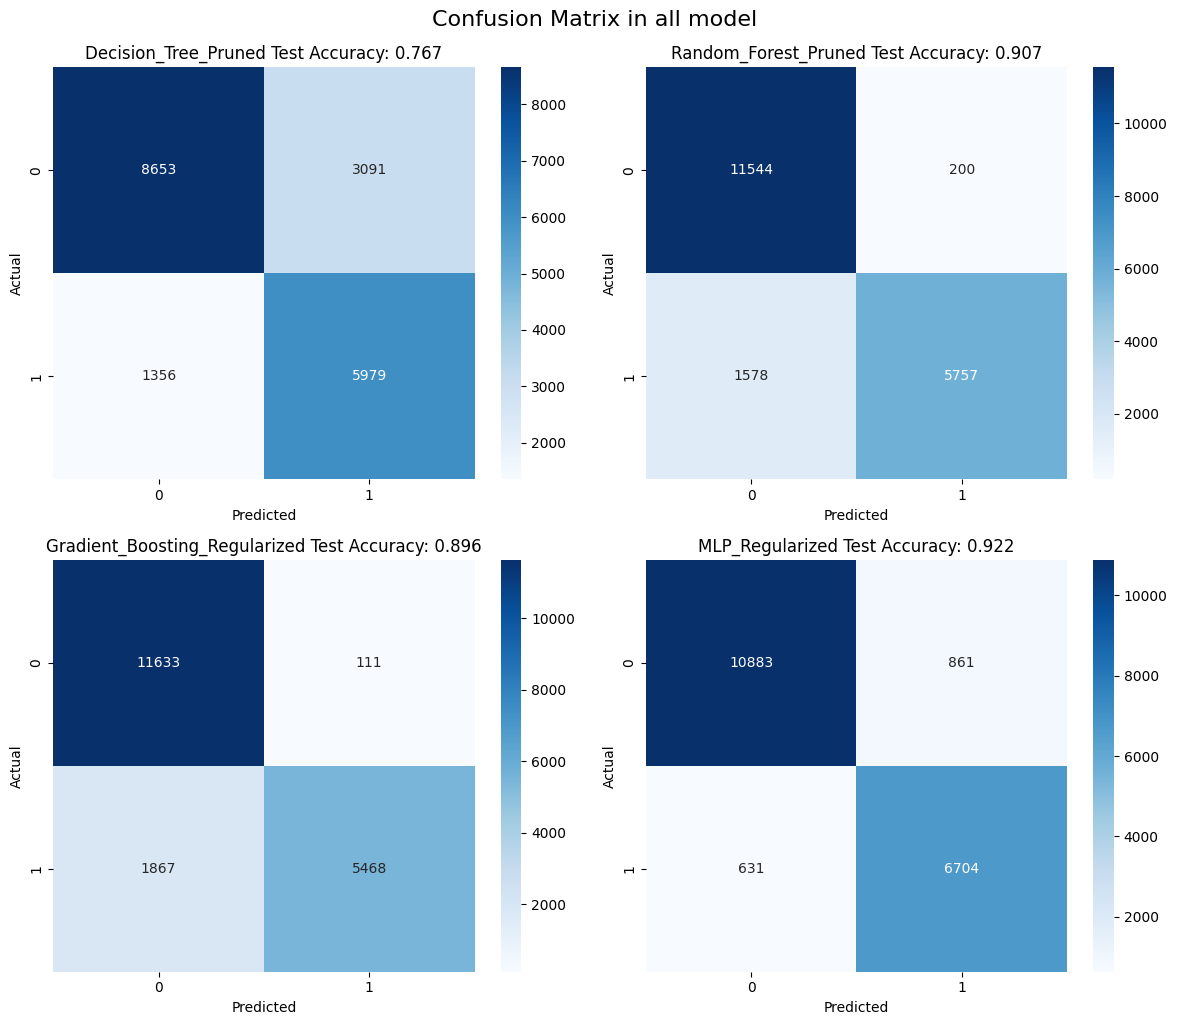

In [7]:

classification_train(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, models=classification_models)

## 分类模型（选取相关系数绝对值大于0.2的特征）

In [8]:
selected_features = correlation_with_target[abs(correlation_with_target) > 0.2]
selected_feature_names = selected_features.index.tolist()

# 提取选中的特征数据
X_selected = X[selected_feature_names]
print(f"\n选中的特征数据:")
print(X_selected.head())


选中的特征数据:
   chronic_count  age  systolic_bp  diastolic_bp  hypertension  \
0              1   52        121.0          76.0             0   
1              2   79        131.0          79.0             0   
2              3   68        160.0          84.0             1   
3              2   53        136.0          83.0             1   
4              1   63        137.0          96.0             1   

   visits_last_year  mental_health  annual_premium  monthly_premium  smoker  \
0                 2              0          876.05            73.00       0   
1                 2              1          445.10            37.09       0   
2                 1              1         1538.02           128.17       0   
3                 3              0          500.93            41.74       0   
4                 1              0          528.68            44.06       0   

   medication_count  arthritis  diabetes  
0                 4          1         0  
1                 3          1  

In [9]:
# 划分数据集
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_selected, y, test_size=0.2, random_state=42)

Model: Decision_Tree_Pruned
模型在训练集上的评估结果：
Accuracy: 0.8360
Precision: 0.8395
Recall: 0.8360
F1-Score: 0.8370

模型在测试集上的评估结果：
Accuracy: 0.8335
Precision: 0.8355
Recall: 0.8335
F1-Score: 0.8342
--------------------------------------------------
训练时间: 0.30秒

Model: Random_Forest_Pruned
模型在训练集上的评估结果：
Accuracy: 0.9279
Precision: 0.9295
Recall: 0.9279
F1-Score: 0.9271

模型在测试集上的评估结果：
Accuracy: 0.9299
Precision: 0.9315
Recall: 0.9299
F1-Score: 0.9291
--------------------------------------------------
训练时间: 7.42秒

Model: Gradient_Boosting_Regularized
模型在训练集上的评估结果：
Accuracy: 0.9231
Precision: 0.9262
Recall: 0.9231
F1-Score: 0.9218

模型在测试集上的评估结果：
Accuracy: 0.9249
Precision: 0.9283
Recall: 0.9249
F1-Score: 0.9237
--------------------------------------------------
训练时间: 8.25秒

Model: MLP_Regularized
模型在训练集上的评估结果：
Accuracy: 0.9504
Precision: 0.9503
Recall: 0.9504
F1-Score: 0.9503

模型在测试集上的评估结果：
Accuracy: 0.9506
Precision: 0.9505
Recall: 0.9506
F1-Score: 0.9505
----------------------------------------

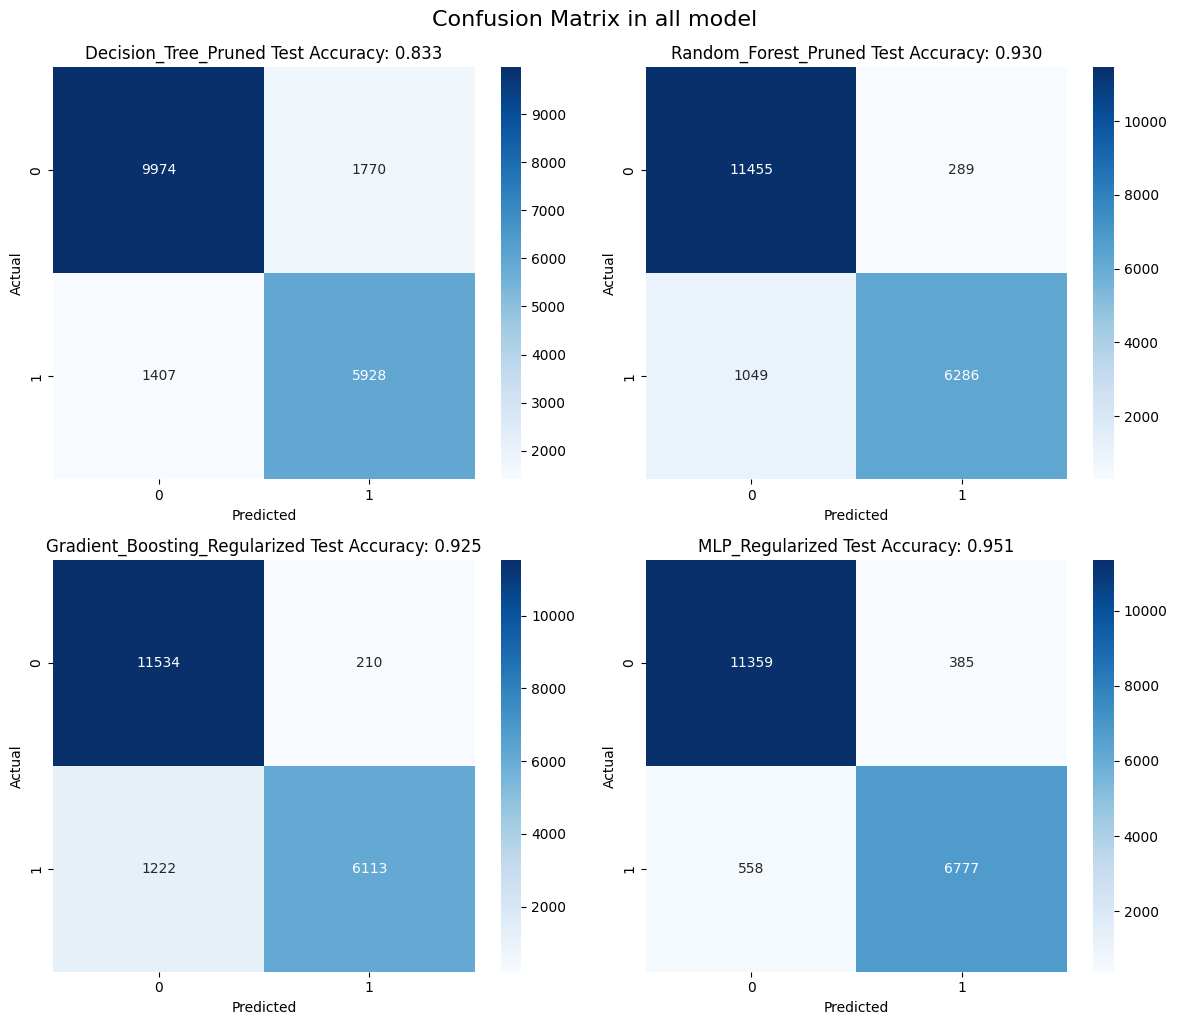

In [10]:
classification_train(X_train=X_train2, X_test=X_test2, y_train=y_train2, y_test=y_test2, models=classification_models)